In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import tensorflow as tf
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle
!mv .kaggle /root/

!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 95% 186M/195M [00:01<00:00, 126MB/s]
100% 195M/195M [00:01<00:00, 144MB/s]


In [3]:
with zipfile.ZipFile('/content/breast-ultrasound-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
DATA_DIR = "/content/Dataset_BUSI_with_GT"

In [5]:
classes = ['benign', 'malignant', 'normal']

In [6]:
folders = os.listdir(DATA_DIR)
names = []
file_names = []
mask_names = []
labels = []
for folder in folders:
  for files in os.listdir(os.path.join(DATA_DIR, folder)):
    names.append(files.split(')')[0])
    labels.append(folder)

for i in range(len(names)):
  file_names.append(os.path.join(DATA_DIR, labels[i], names[i]) + ').png')
  mask_names.append(os.path.join(DATA_DIR, labels[i], names[i]) + ')_mask.png')


In [7]:
df = pd.DataFrame({'image': file_names,
                   'mask': mask_names,
                   'label': labels}, 
                  columns=['image', 'mask', 'label']).sample(frac = 1, random_state=1).reset_index(drop=True)
df.head()

,image,mask,label
0,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
2,/content/Dataset_BUSI_with_GT/normal/normal (8...,/content/Dataset_BUSI_with_GT/normal/normal (8...,normal
3,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
4,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign


In [8]:
df.drop_duplicates(subset=['image', 'mask', 'label'], keep='first', inplace=True)
df.head()

,image,mask,label
0,/content/Dataset_BUSI_with_GT/malignant/malign...,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
2,/content/Dataset_BUSI_with_GT/normal/normal (8...,/content/Dataset_BUSI_with_GT/normal/normal (8...,normal
3,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
4,/content/Dataset_BUSI_with_GT/benign/benign (1...,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign


In [9]:
print(f"There {df.shape[0]} images in this dataset")

There 780 images in this dataset


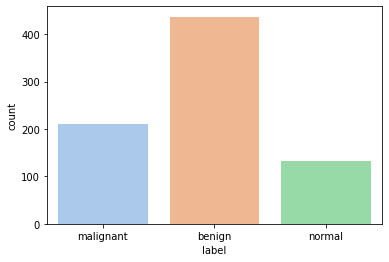

In [10]:
sns.countplot(x=df["label"], palette='pastel')

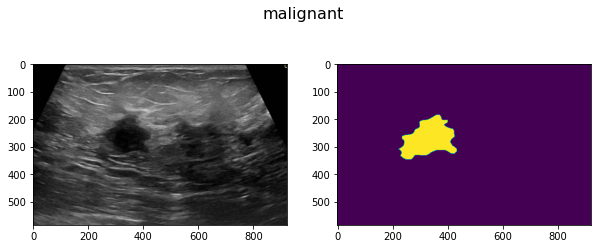

In [11]:
index = 8

plt.figure(figsize=(10,4))
plt.suptitle(df.iloc[index]['label'], fontsize=16)
plt.subplot(1,2,1)
plt.imshow(plt.imread(df.iloc[index]['image']))
plt.subplot(1,2,2)
plt.imshow(plt.imread(df.iloc[index]['mask']))
plt.show()

In [13]:
exclude_normal = df[df['label'] != 'normal']
shape = 128
images_path = list(exclude_normal['image'])
masks_path = list(exclude_normal['mask'])
images = np.zeros((647, shape, shape, 3))
masks = np.zeros((647, shape, shape))

for i in range(len(images_path)):
  img = plt.imread(images_path[i])
  img_resized = cv2.resize(img,(shape,shape))
  images[i] = img_resized

  mask = plt.imread(masks_path[i])
  mask_resized = cv2.resize(mask,(shape,shape))
  masks[i] = mask_resized

In [14]:
print(f"The shape of images (except normal ones): {images.shape}")
print(f"The shape of masks (except normal ones): {masks.shape}")

The shape of images (except normal ones): (647, 128, 128, 3)
The shape of masks (except normal ones): (647, 128, 128)


In [ ]:
# images = images/255
# masks = masks/255
# masks[masks > 1.0] = 1.0

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.2, random_state = 3)

In [16]:
def dice_coefficient(y_true, y_pred, axis=(1, 2), epsilon=0.00001):
    dice_numerator = 2 * tf.keras.backend.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_true, axis=axis) + tf.keras.backend.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = tf.keras.backend.mean(dice_numerator/dice_denominator)

    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2), epsilon=0.00001):
    dice_numerator = 2 * tf.keras.backend.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.keras.backend.sum(y_true ** 2, axis=axis) + tf.keras.backend.sum(y_pred ** 2, axis=axis) + epsilon
    dice_loss = 1 - tf.keras.backend.mean(dice_numerator/dice_denominator)
    return dice_loss

In [17]:
def create_convolution_block(input_layer, n_filters, batch_normalization=True,
                             kernel=(3, 3),padding='same', strides=(1, 1),
                             instance_normalization=False):
    layer = Conv2D(n_filters, kernel, padding=padding,kernel_initializer = 'he_normal', strides=strides)(input_layer)
    if batch_normalization:
      layer = BatchNormalization()(layer)
    return Activation('relu')(layer)

In [18]:
dropout = 0.3
numFilters = 32
doBatchNorm = True

In [19]:
# 1 more layer was added (the different between this notebook and the one in github)

input_layer = Input(shape=(shape, shape, 3))
down_depth_0_layer_0 = create_convolution_block(input_layer, numFilters * 1, kernel = (3,3))
down_depth_0_layer_1 = create_convolution_block(down_depth_0_layer_0, numFilters * 2, kernel = (3,3))
down_depth_0_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_0_layer_1)
down_depth_0_layer_drop = Dropout(dropout)(down_depth_0_layer_pool)

down_depth_1_layer_0 = create_convolution_block(down_depth_0_layer_drop, numFilters * 2, kernel = (3,3))
down_depth_1_layer_1 = create_convolution_block(down_depth_1_layer_0, numFilters * 4, kernel = (3,3))
down_depth_2_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_1_layer_1)
down_depth_1_layer_drop = Dropout(dropout)(down_depth_2_layer_pool)

down_depth_2_layer_0 = create_convolution_block(down_depth_1_layer_drop, numFilters * 4, kernel = (3,3))
down_depth_2_layer_1 = create_convolution_block(down_depth_2_layer_0, numFilters * 8, kernel = (3,3))
down_depth_2_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_2_layer_1)
down_depth_2_layer_drop = Dropout(dropout)(down_depth_2_layer_pool)

down_depth_3_layer_0 = create_convolution_block(down_depth_2_layer_drop, numFilters * 8, kernel = (3,3))
down_depth_3_layer_1 = create_convolution_block(down_depth_3_layer_0, numFilters * 16, kernel = (3,3))
down_depth_3_layer_pool = MaxPooling2D(pool_size=(2,2))(down_depth_3_layer_1)
down_depth_3_layer_drop = Dropout(dropout)(down_depth_3_layer_pool)

depth_2_layer_0 = create_convolution_block(down_depth_3_layer_drop, numFilters * 16, kernel = (3,3))

up_depth_3_layer_0 = Conv2DTranspose(32 * 8, kernel_size=(3,3), strides=(2,2), padding='same')(depth_2_layer_0)
up_depth_3_concat = concatenate([up_depth_3_layer_0,down_depth_3_layer_1])
up_depth_3_layer_drop = Dropout(dropout)(up_depth_3_concat)
down_depth_3_layer_0 = create_convolution_block(up_depth_3_layer_drop, numFilters * 16, kernel = (3,3))
down_depth_3_layer_1 = create_convolution_block(down_depth_3_layer_0, numFilters * 8, kernel = (3,3))

up_depth_2_layer_0 = Conv2DTranspose(32 * 4, kernel_size=(3,3), strides=(2,2), padding='same')(down_depth_3_layer_1)
up_depth_2_concat = concatenate([up_depth_2_layer_0,down_depth_2_layer_1])
up_depth_2_layer_drop = Dropout(dropout)(up_depth_2_concat)
down_depth_2_layer_0 = create_convolution_block(up_depth_2_layer_drop, numFilters * 8, kernel = (3,3))
down_depth_2_layer_1 = create_convolution_block(down_depth_2_layer_0, numFilters * 4, kernel = (3,3))

up_depth_1_layer_0 = Conv2DTranspose(32 * 2, kernel_size=(3,3), strides=(2,2), padding='same')(down_depth_2_layer_1)
up_depth_1_concat = concatenate([up_depth_1_layer_0,down_depth_1_layer_1])
up_depth_1_layer_drop = Dropout(dropout)(up_depth_1_concat)
down_depth_1_layer_0 = create_convolution_block(up_depth_1_layer_drop, numFilters * 4, kernel = (3,3))
down_depth_1_layer_1 = create_convolution_block(down_depth_1_layer_0, numFilters * 2, kernel = (3,3))

up_depth_0_layer_0 = Conv2DTranspose(32 * 1, kernel_size=(3,3), strides=(2,2), padding='same')(down_depth_1_layer_1)
up_depth_0_concat = concatenate([up_depth_0_layer_0,down_depth_0_layer_1])
up_depth_0_layer_drop = Dropout(dropout)(up_depth_0_concat)
down_depth_0_layer_0 = create_convolution_block(up_depth_0_layer_drop, numFilters * 2, kernel = (3,3))
down_depth_0_layer_1 = create_convolution_block(down_depth_0_layer_0, numFilters * 1, kernel = (3,3))

final_conv = Conv2D(filters=1,kernel_size=(1,1))(down_depth_0_layer_1)
final_activation = Activation('sigmoid')(final_conv)

model = Model(inputs=input_layer, outputs=final_activation)
model.compile(optimizer= tf.keras.optimizers.Adam(lr=0.0001), loss=soft_dice_loss ,metrics=[dice_coefficient, 'accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [357]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

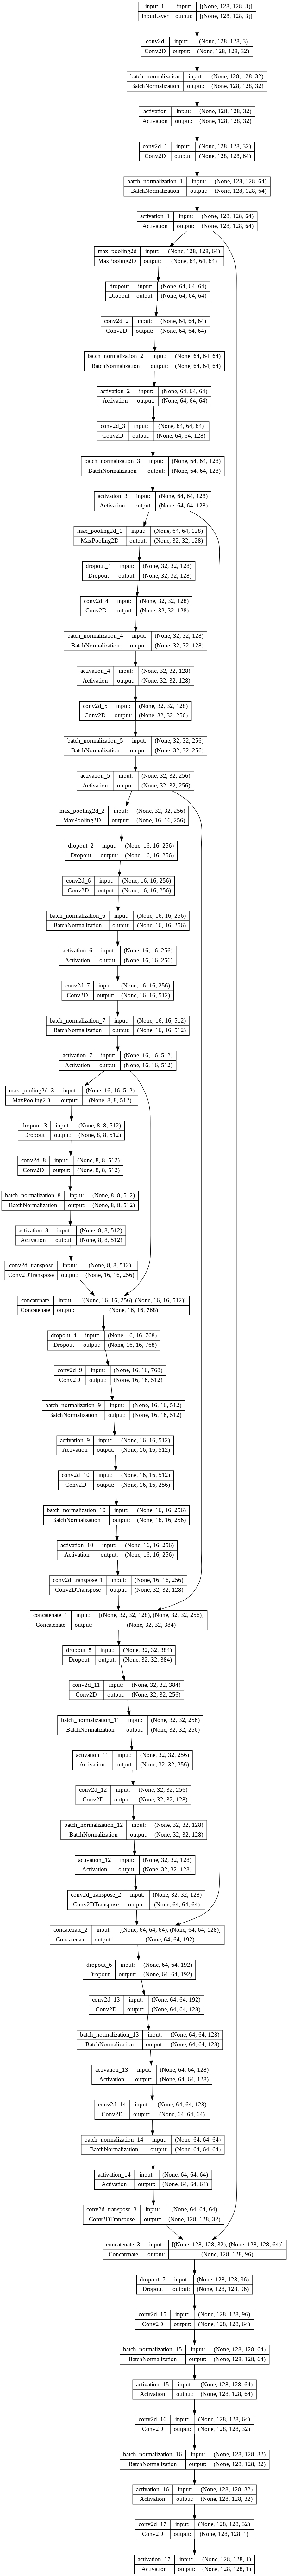

In [358]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
17/17 [==============================] - 29s 673ms/step - loss: 0.7585 - dice_coefficient: 0.1423 - accuracy: 0.7211 - val_loss: 0.7181 - val_dice_coefficient: 0.1672 - val_accuracy: 0.7443
Epoch 2/50
17/17 [==============================] - 6s 333ms/step - loss: 0.6666 - dice_coefficient: 0.2027 - accuracy: 0.7957 - val_loss: 0.7362 - val_dice_coefficient: 0.1437 - val_accuracy: 0.8878
Epoch 3/50
17/17 [==============================] - 6s 334ms/step - loss: 0.5620 - dice_coefficient: 0.2713 - accuracy: 0.8793 - val_loss: 0.6743 - val_dice_coefficient: 0.1812 - val_accuracy: 0.8998
Epoch 4/50
17/17 [==============================] - 6s 330ms/step - loss: 0.5067 - dice_coefficient: 0.3008 - accuracy: 0.9117 - val_loss: 0.6833 - val_dice_coefficient: 0.2417 - val_accuracy: 0.6565
Epoch 5/50
17/17 [==============================] - 6s 328ms/step - loss: 0.4825 - dice_coefficient: 0.3097 - accuracy: 0.9191 - val_loss: 0.6794 - val_dice_coefficient: 0.2490 - val_accuracy: 0.6577

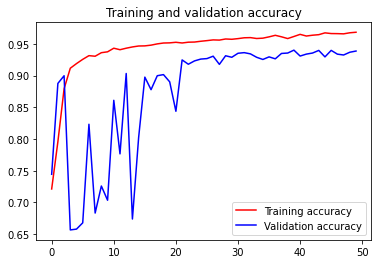

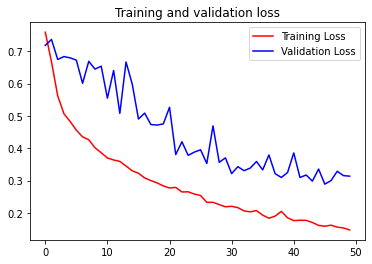

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('breast.h5')

In [346]:
y_predicted_prob = model.predict(X_test)
y_predicted_prob.shape

5/5 [==============================] - 0s 100ms/step


(130, 128, 128, 1)

In [347]:
threshold = 0.5
y_predicted = np.copy(y_predicted_prob)

y_predicted[y_predicted > threshold] = 1.0
y_predicted[y_predicted <= threshold] = 0.0

y_predicted.shape
y_predicted_new = np.squeeze(y_predicted, axis=(3,))
y_predicted_new.shape

(130, 128, 128)

In [325]:
def compute_class_metrics(pred, label):
    fp = len(np.where(pred - label  == 1)[0])
    fn = len(np.where(pred - label  == -1)[0])
    tp = len(np.where(pred + label == 2)[0])
    tn = len(np.where(pred + label == 0)[0])

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)

    return sensitivity, specificity, accuracy, PPV, NPV

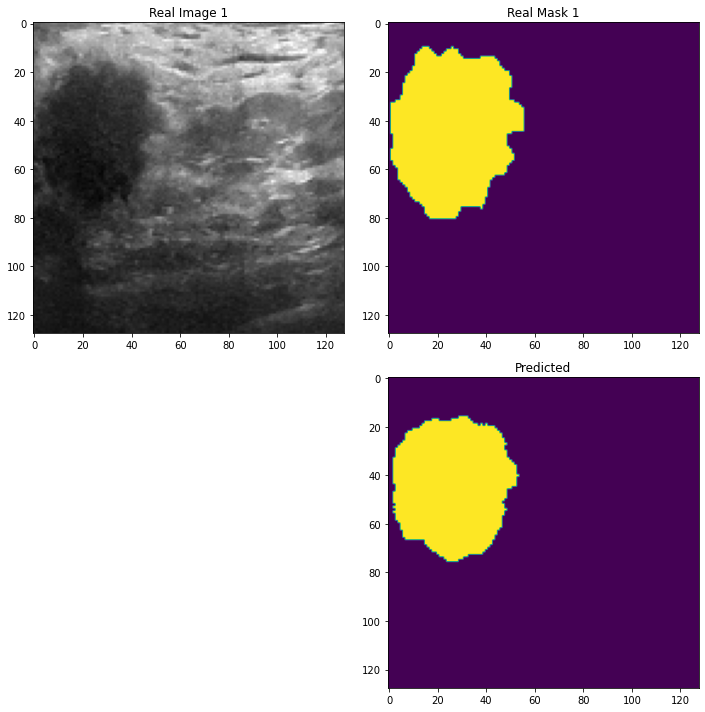

In [348]:
index1 = 40
plt.figure(figsize=(10,10))
plt.subplot(2,2,1).set_title("Real Image 1")
plt.imshow(X_test[index1])
plt.subplot(2,2,2).set_title("Real Mask 1")
plt.imshow(y_test[index1])
plt.subplot(2,2,4).set_title("Predicted")
plt.imshow(y_predicted[index1][:, :, 0])

plt.tight_layout()
plt.show()

In [349]:
sensitivity, specificity, accuracy, PPV, NPV = compute_class_metrics(y_predicted_new[index1], y_test[index1])
print('Image 1 metrics:')
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"PPV: {PPV}")
print(f"NPV: {NPV}")

Image 1 metrics:
Sensitivity: 0.8156228008444757
Specificity: 0.9984492689410722
Accuracy: 0.96673583984375
PPV: 0.9910218041898247
NPV: 0.9626913492346031


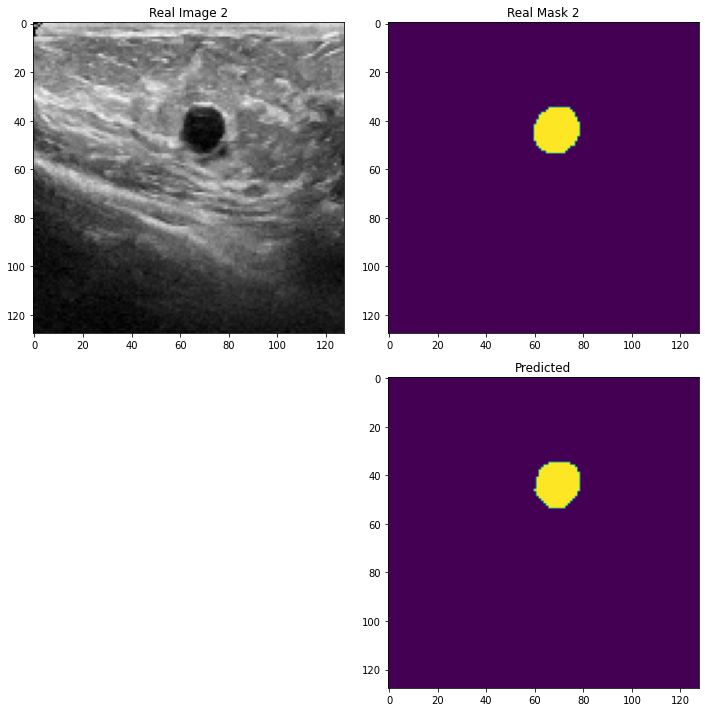

In [350]:
index2 = 6
plt.figure(figsize=(10,10))
plt.subplot(2,2,1).set_title("Real Image 2")
plt.imshow(X_test[index2])
plt.subplot(2,2,2).set_title("Real Mask 2")
plt.imshow(y_test[index2])
plt.subplot(2,2,4).set_title("Predicted")
plt.imshow(y_predicted[index2][:, :, 0])

plt.tight_layout()
plt.show()

In [351]:
sensitivity, specificity, accuracy, PPV, NPV = compute_class_metrics(y_predicted_new[index2], y_test[index2])
print('Image 2 metrics:')
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"PPV: {PPV}")
print(f"NPV: {NPV}")

Image 2 metrics:
Sensitivity: 0.9457627118644067
Specificity: 0.9996270743986575
Accuracy: 0.9986572265625
PPV: 0.9789473684210527
NPV: 0.9990061494502764


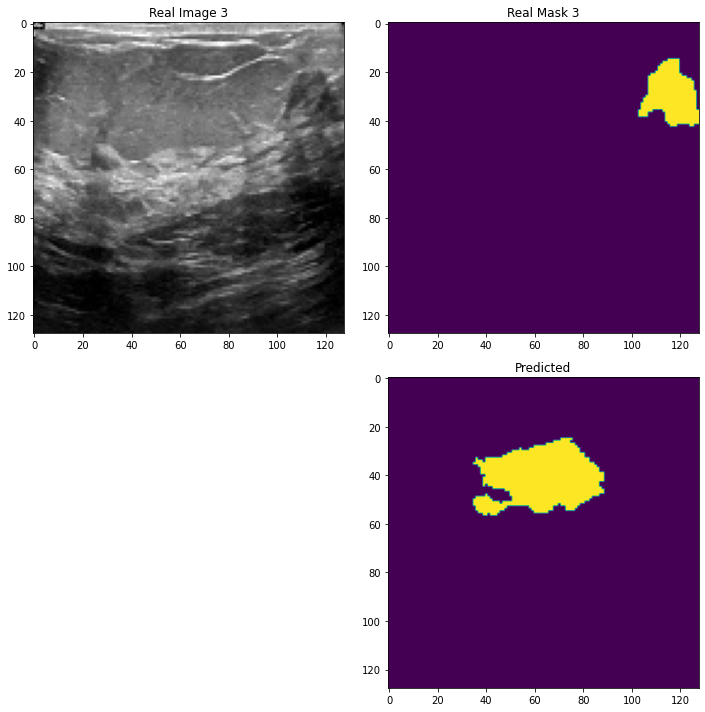

In [352]:
index3 = 120
plt.figure(figsize=(10,10))
plt.subplot(2,2,1).set_title("Real Image 3")
plt.imshow(X_test[index3])
plt.subplot(2,2,2).set_title("Real Mask 3")
plt.imshow(y_test[index3])
plt.subplot(2,2,4).set_title("Predicted")
plt.imshow(y_predicted[index3][:, :, 0])

plt.tight_layout()
plt.show()

In [336]:
sensitivity, specificity, accuracy, PPV, NPV = compute_class_metrics(y_predicted_new[index3], y_test[index3])
print('Image 3 metrics:')
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"PPV: {PPV}")
print(f"NPV: {NPV}")

Image 3 metrics:
Sensitivity: 0.0
Specificity: 0.9282756024096386
Accuracy: 0.90289306640625
PPV: 0.0
NPV: 0.9706056033068696


In [353]:
sensitivity, specificity, accuracy, PPV, NPV = compute_class_metrics(y_predicted_new, y_test)
print('Image 1 metrics:')
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"PPV: {PPV}")
print(f"NPV: {NPV}")

Image 1 metrics:
Sensitivity: 0.5583319770081465
Specificity: 0.9881652311745233
Accuracy: 0.9410484900841346
PPV: 0.8531151832460733
NPV: 0.947844339240916


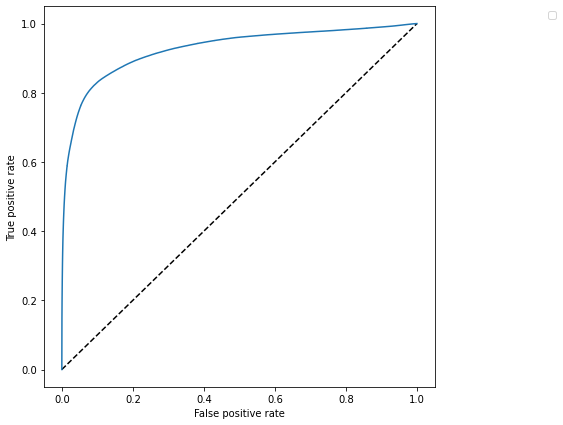

In [356]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def plot_roc_curve(true_y, y_prob):
    xlabel = "False positive rate"
    ylabel = "True positive rate"
    a, b, threshold = roc_curve(true_y.flatten(), y_prob.flatten())
    plt.figure(1, figsize=(7, 7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(a, b)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

plot_roc_curve(y_test, y_predicted_prob)